# MHD Shock solver

## Equations

In [36]:
%config InteractiveShell.ast_node_interactivity = 'last_expr_or_assign'

In [37]:
import sympy
sympy.init_printing()
def pair_across_jump(symbol, **assumptions):
    return sympy.symbols("{" + symbol + "}_{1:3}", **assumptions)
Bx = pair_across_jump("B_x", real=True)

In [38]:
Vx = pair_across_jump("V_x", real=True)

In [39]:
Vy = pair_across_jump("V_y", real=True)

In [40]:
By = pair_across_jump("B_y", real=True)

In [41]:
Eq933 = sympy.Eq(Bx[0], Bx[1])

In [42]:
Eq934 = sympy.Eq(Vx[0] * By[0] - Vy[0] * Bx[0],
                 Vx[1] * By[1] - Vy[1] * Bx[1])

In [43]:
rho = pair_across_jump(r"\rho", positive=True)

In [44]:
Eq935 = sympy.Eq(rho[0] * Vx[0],
                 rho[1] * Vx[1])

In [45]:
p = pair_across_jump("p", positive = True)

In [46]:
mu_0 = sympy.symbols("\mu_0", positive = True)

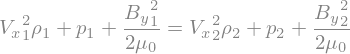

In [47]:
Eq936 = sympy.Eq(rho[0] * Vx[0]**2 + p[0] + By[0]**2 / 2 / mu_0,
                 rho[1] * Vx[1]**2 + p[1] + By[1]**2 / 2 / mu_0)

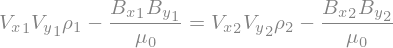

In [48]:
Eq937 = sympy.Eq(rho[0] * Vx[0] * Vy[0] - Bx[0] * By[0] / mu_0,
                 rho[1] * Vx[1] * Vy[1] - Bx[1] * By[1] / mu_0)

In [49]:
V2 = (Vx[0]**2 + Vy[0]**2, Vx[1]**2 + Vy[1]**2)

In [50]:
Gamma = sympy.symbols("Gamma", positive=True)

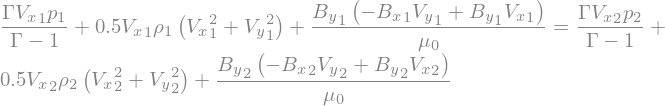

In [51]:
Eq938 = sympy.Eq(
    1/2 * rho[0] * V2[0] * Vx[0] + Gamma / (Gamma - 1) * p[0] * Vx[0] + By[0] * (Vx[0] * By[0] - Vy[0] * Bx[0]) / mu_0,
    1/2 * rho[1] * V2[1] * Vx[1] + Gamma / (Gamma - 1) * p[1] * Vx[1] + By[1] * (Vx[1] * By[1] - Vy[1] * Bx[1]) / mu_0,
)

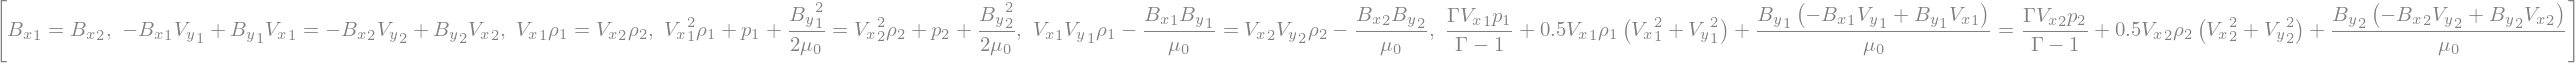

In [52]:
all_equations = [Eq933, Eq934, Eq935, Eq936, Eq937, Eq938]

In [53]:
names_to_symbols_dict = {}
for key, pair in {
    "Bx": Bx,
    "By": By,
    "Vx": Vx,
    "Vy": Vy,
    "p": p,
    "rho": rho}.items():
    for i, value in enumerate(pair):
        names_to_symbols_dict[f"{key}{i}"] = value
names_to_symbols_dict

{'Bx0': {B_x}_{1},
 'Bx1': {B_x}_{2},
 'By0': {B_y}_{1},
 'By1': {B_y}_{2},
 'Vx0': {V_x}_{1},
 'Vx1': {V_x}_{2},
 'Vy0': {V_y}_{1},
 'Vy1': {V_y}_{2},
 'p0': {p}_{1},
 'p1': {p}_{2},
 'rho0': {\rho}_{1},
 'rho1': {\rho}_{2}}

## Hydrodynamic approximation

In [54]:
hydrodynamics_substitutions = {
    Bx[0]:0,
    Bx[1]:0,
    By[0]:0,
    By[1]:0
}

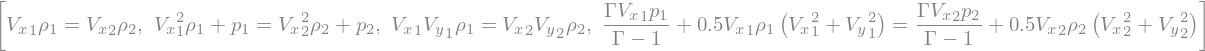

In [55]:
hydrodynamic_equations = [equation.subs(hydrodynamics_substitutions) for equation in all_equations] 
hydrodynamic_equations = [equation for equation in hydrodynamic_equations if equation != True]

## Initial interface design

In [56]:
import time

In [57]:
import astropy.units as u
from plasmapy.utils.decorators import validate_quantities

In [59]:
# @validate_quantities  # TODO
def solve_RH(
    Bx0 = None,
    Bx1 = None,
    By0 = None,
    By1 = None,
    Vx0 = None,
    Vx1 = None,
    Vy0 = None,
    Vy1 = None,
    rho0 = None,
    rho1 = None,
    p0 = None,
    p1 = None,
):
    all_arguments = dict(
        Bx0=Bx0,
        Bx1=Bx1,
        By0=By0,
        By1=By1,
        Vx0=Vx0,
        Vx1=Vx1,
        Vy0=Vy0,
        Vy1=Vy1,
        rho0=rho0,
        rho1=rho1,
        p0=p0,
        p1=p1,
    )
    specified_arguments = {arg: value for arg, value in all_arguments.items() if value is not None}
    assert len(specified_arguments) == 6, "Problem is either overconstrained or underconstrained"
    solve_for_these = [names_to_symbols_dict[arg] for arg in all_arguments if arg not in specified_arguments]
    print(f"I'll try to solve for these {len(solve_for_these)} unknowns:")
    display(solve_for_these)
    substitutions = {names_to_symbols_dict[key]: value for key, value in specified_arguments.items()}
    
    substitutions[Gamma] = 2    # TODO
    substitutions[mu_0] = 0.1    # TODO
    print("Given these substitutions")
    display(substitutions)
    subs_equations = [eq.subs(substitutions) for eq in all_equations]
    print(f"These are the {len(subs_equations)} equations I'll be trying to solve:")
    display(subs_equations)
    print("Here I go!")
    start_time = time.time()
    solution = sympy.solve(subs_equations, solve_for_these,
                          simplify=False,
#                           rational=False,
                          ) # more wrapping will happen here, of course
    end_time = time.time()
    print(f"That took {end_time - start_time:.2f}s...")
    return [dict(zip(solve_for_these, sol)) for sol in solution]
    
    
output = solve_RH(
    Bx0=1,
    By0=1,
    Vx0=1,
    Vy0=1,
    rho0=1,
    p0=1
)

I'll try to solve for these 6 unknowns:


Given these substitutions


These are the 6 equations I'll be trying to solve:


Here I go!
That took 6.80s...
